<a href="https://colab.research.google.com/github/dhcryan/kaggle_challenge_/blob/main/week4/donghun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Store Sales - Time Series Forecasting**

 * For grocery stores, more accurate forecasting can decrease food waste related to overstocking and improve customer satisfaction.

 * you'll build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -qq '/content/drive/MyDrive/store-sales-time-series-forecasting.zip'

replace holidays_events.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
from xgboost import XGBClassifier
from xgboost import  XGBRegressor

cpu


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import seaborn as sns
import calendar
import datetime

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge

In [7]:
path='/content/'

## Read data

index_col=0 을 통해 column 0을 인덱스로

### df_data

**holidays data**

In [95]:
df_holidays = pd.read_csv(path+'holidays_events.csv',
                          dtype={
                              'type':'category',
                              'locale':'category',
                              'locale_name':'category',
                              'description': 'category',
                              'transferred': 'bool',
                          },
                          parse_dates=['date'],
                          infer_datetime_format=True,
                          )
df_holidays["date"] = df_holidays["date"].dt.to_period('D')
df_holidays=df_holidays.set_index('date').sort_index()
df_holidays.head()
# df_holidays=df_holidays.set_index('date').to_period('D')

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


뭔가 **train 데이터**에서 가게별로, 가족별로, 날짜별로 판매량, 행사상품따위를 보고 싶다는 생각이 듦

In [96]:
train=pd.read_csv(path+'train.csv',
                  dtype={
                      # 'store_nbr':'category',
                      'family':'category',
                      'sales':'float32',
                      "onpromotion":"uint32"
                  },
                  parse_dates=['date'],
                  infer_datetime_format=True,
                  index_col=0)
train['date']=train.date.dt.to_period('D')
# train=train.set_index(['date', 'store_nbr', 'family']).sort_index()
train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


**test 데이터**도 마찬가지로 만들어줌

In [97]:
test=pd.read_csv(path+'test.csv',
                 dtype={
                    #  'store_nbr':'category',
                      'family':'category',
                      'onpromotion':'category',
                 },
                 parse_dates=['date'],
                  infer_datetime_format=True,)
test['date'] = test.date.dt.to_period('D')
# test = test.set_index(['date', 'store_nbr', 'family']).sort_values('id')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


**oil data**

In [98]:
df_oil=pd.read_csv(path+'oil.csv',
                 dtype={
                     'dcoilwtico':'float64',
                 },
                 parse_dates=['date'],
                  infer_datetime_format=True,)
df_oil['date'] = df_oil.date.dt.to_period('D')
df_oil.rename(columns={'dcoilwtico':'oilprice'},inplace=True)
df_oil.head()

,date,oilprice
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


Text(0, 0.5, 'Oil_price')

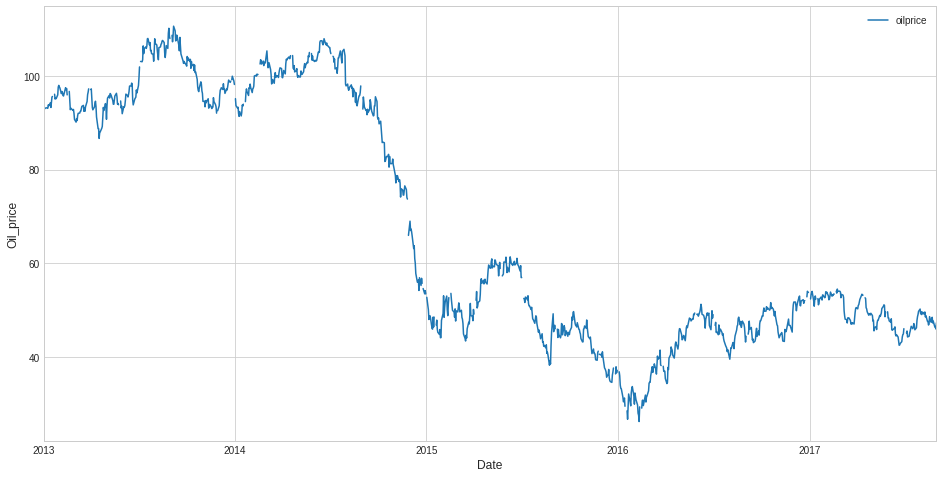

In [99]:
ax=df_oil.set_index('date').plot(figsize=(16,8))
ax.set_xlabel('Date',fontsize='large')
ax.set_ylabel('Oil_price',fontsize='large')

**stores data**

In [100]:
df_stores=pd.read_csv(path+'stores.csv',
                 dtype={
                    #  "store_nbr":"category",
                      "city":"category",
                      "state":"category",
                      "type":"category",
                      "cluster":"category",
                 },
                 )
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


**transactions**

In [101]:
df_trans = pd.read_csv(path+'transactions.csv',
            dtype={
                "transaction":"uint32",
            },
            parse_dates = ["date"],
            infer_datetime_format=True,
           )
df_trans["date"] = df_trans["date"].dt.to_period('D')
df_trans.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [102]:
df_holidays['transferred'].value_counts()

False    338
True      12
Name: transferred, dtype: int64

In [103]:
df_stores.type.value_counts()

D    18
C    15
A     9
B     8
E     4
Name: type, dtype: int64

df_stores 말고는 date 데이터가 있는데 object로 되어 있으니 시계열로 표현하기 위해서 datetime으로 변경

In [104]:
# df_oil['date'] = pd.to_datetime(df_oil['date'], format = "%Y-%m-%d")
# df_trans['date'] = pd.to_datetime(df_trans['date'], format = "%Y-%m-%d")
# train['date'] = pd.to_datetime(train['date'], format = "%Y-%m-%d")
# test['date'] = pd.to_datetime(test['date'], format = "%Y-%m-%d")

Let's find the relationship between crude oil and grocery sales and transactions.

Weekly average sales

<Figure size 432x288 with 0 Axes>

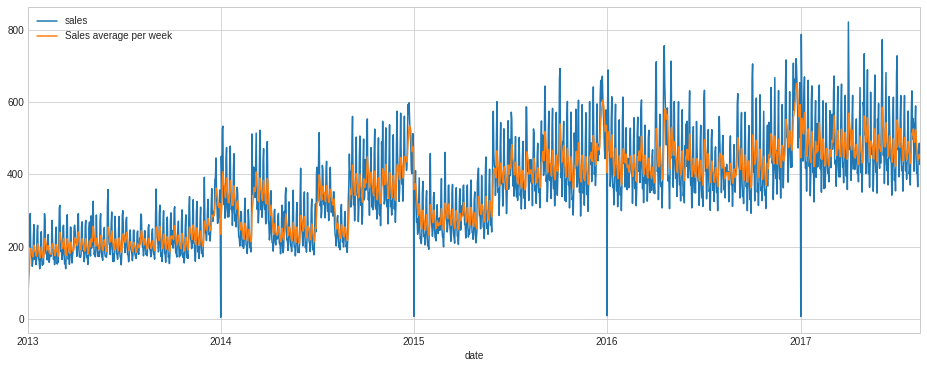

In [105]:
fig=plt.figure()
sales_mean=train.groupby('date').agg({'sales':'mean'}).reset_index()
sales_mean['Sales average per week']=sales_mean['sales'].ewm(span=7,adjust=False).mean()
ax1=sales_mean.plot(x='date',y=['sales','Sales average per week'],figsize=(16,6))
ax1.grid(True)
plt.show()

### null data 파악 및 merge



*   `store_nbr` : the store at which the products are sold.
*   `family` : the type of product sold.
*   `sales` : total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
*   `onpromotion` : total number of items in a product family that were being promoted at a store at a given date.



In [106]:
train_=train.merge(df_stores,how='left',on='store_nbr')
train_=train_.merge(df_oil,how='left',on='date')
test_=test.merge(df_stores,how='left',on='store_nbr')
test_=test_.merge(df_oil,how='left',on='date')

In [107]:
train.set_index('date',inplace=True)
train.head(5)

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,1,BABY CARE,0.0,0
2013-01-01,1,BEAUTY,0.0,0
2013-01-01,1,BEVERAGES,0.0,0
2013-01-01,1,BOOKS,0.0,0


In [108]:
train_ = pd.merge(train_.set_index('date'),df_holidays,on='date',how='left')
train_ = train_.rename(columns={"type_x":"type","type_y":"holidays_type"})

In [109]:
test_ = pd.merge(test_.set_index('date'),df_holidays,on='date',how='left')
test_ = test_.rename(columns={"type_x":"type","type_y":"holidays_type"})

In [110]:
train_.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 3054348 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 14 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   store_nbr      3054348 non-null  int64   
 1   family         3054348 non-null  category
 2   sales          3054348 non-null  float32 
 3   onpromotion    3054348 non-null  uint32  
 4   city           3054348 non-null  category
 5   state          3054348 non-null  category
 6   type           3054348 non-null  category
 7   cluster        3054348 non-null  category
 8   oilprice       2099196 non-null  float64 
 9   holidays_type  502524 non-null   category
 10  locale         502524 non-null   category
 11  locale_name    502524 non-null   category
 12  description    502524 non-null   category
 13  transferred    502524 non-null   object  
dtypes: category(9), float32(1), float64(1), int64(1), object(1), uint32(1)
memory usage: 142.7+ MB


In [111]:
test_.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 28512 entries, 2017-08-16 to 2017-08-31
Freq: D
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             28512 non-null  int64   
 1   store_nbr      28512 non-null  int64   
 2   family         28512 non-null  category
 3   onpromotion    28512 non-null  category
 4   city           28512 non-null  category
 5   state          28512 non-null  category
 6   type           28512 non-null  category
 7   cluster        28512 non-null  category
 8   oilprice       21384 non-null  float64 
 9   holidays_type  1782 non-null   category
 10  locale         1782 non-null   category
 11  locale_name    1782 non-null   category
 12  description    1782 non-null   category
 13  transferred    1782 non-null   object  
dtypes: category(10), float64(1), int64(2), object(1)
memory usage: 1.4+ MB


In [112]:
train_['oilprice']=train_['oilprice'].fillna(method='bfill',axis=0)
test_['oilprice']=test_['oilprice'].fillna(method='bfill',axis=0)

In [113]:
train_['year']=train_.index.year
train_['weekday']=train_.index.dayofweek
train_['month']=train_.index.month
train_['day']=train_.index.day
train_

,store_nbr,family,sales,onpromotion,city,state,type,cluster,oilprice,holidays_type,locale,locale_name,description,transferred,year,weekday,month,day
date,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000000,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1
2013-01-01,1,BABY CARE,0.000000,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1
2013-01-01,1,BEAUTY,0.000000,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1
2013-01-01,1,BEVERAGES,0.000000,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1
2013-01-01,1,BOOKS,0.000000,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,9,POULTRY,438.132996,0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2017,1,8,15
2017-08-15,9,PREPARED FOODS,154.552994,1,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2017,1,8,15
2017-08-15,9,PRODUCE,2419.729004,148,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,2017,1,8,15


In [114]:
test_['year']=test_.index.year
test_['weekday']=test_.index.dayofweek
test_['month']=test_.index.month
test_['day']=test_.index.day
test_

,id,store_nbr,family,onpromotion,city,state,type,cluster,oilprice,holidays_type,locale,locale_name,description,transferred,year,weekday,month,day
date,,,,,,,,,,,,,,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.80,NaN,NaN,NaN,NaN,NaN,2017,2,8,16
2017-08-16,3000889,1,BABY CARE,0,Quito,Pichincha,D,13,46.80,NaN,NaN,NaN,NaN,NaN,2017,2,8,16
2017-08-16,3000890,1,BEAUTY,2,Quito,Pichincha,D,13,46.80,NaN,NaN,NaN,NaN,NaN,2017,2,8,16
2017-08-16,3000891,1,BEVERAGES,20,Quito,Pichincha,D,13,46.80,NaN,NaN,NaN,NaN,NaN,2017,2,8,16
2017-08-16,3000892,1,BOOKS,0,Quito,Pichincha,D,13,46.80,NaN,NaN,NaN,NaN,NaN,2017,2,8,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,3029395,9,POULTRY,1,Quito,Pichincha,B,6,47.26,NaN,NaN,NaN,NaN,NaN,2017,3,8,31
2017-08-31,3029396,9,PREPARED FOODS,0,Quito,Pichincha,B,6,47.26,NaN,NaN,NaN,NaN,NaN,2017,3,8,31
2017-08-31,3029397,9,PRODUCE,1,Quito,Pichincha,B,6,47.26,NaN,NaN,NaN,NaN,NaN,2017,3,8,31


## EDA

In [ ]:
train_cp=train_.copy()
# train_cp=train_cp.set_index('date')
daily_sales=train_cp.resample('D').sales.mean().to_frame()
weekly_sales=train_cp.resample('W').sales.mean().to_frame()
monthly_sales=train_cp.resample('M').sales.mean().to_frame()

### time series data analysis

In [117]:
avg_sales=daily_sales.squeeze()
moving_avg=avg_sales.rolling(window=365,min_periods=183,center=True).mean()

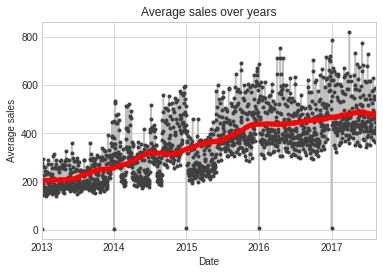

In [118]:
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)
ax=avg_sales.plot(**plot_params)
ax=moving_avg.plot(color='red',linewidth=5)
plt.xlabel('Date')
plt.ylabel('Average sales')
plt.title('Average sales over years')
plt.show()

### Trend forecast

In [119]:
plt.style.use('seaborn-whitegrid')
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

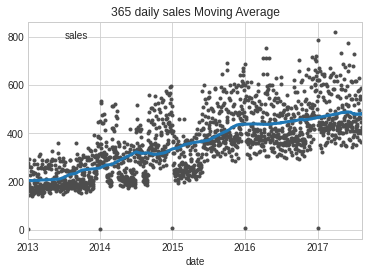

In [120]:
# 이동 평균 구해보기 
moving_average=daily_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()
ax1=daily_sales.plot(style='.',color='0.3')
moving_average.plot(
    ax=ax1,linewidth=3,title='365 daily sales Moving Average',legend=False,
);

In [121]:
# train[train['date']<'2013-12-31']['store_nbr'].value_counts()

In [122]:
from statsmodels.tsa.deterministic import DeterministicProcess
# 날짜별로
dp = DeterministicProcess(
    index=daily_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

In [123]:
X = dp.in_sample()
X.head()
#in_sample 은 날짜별로 인덱스를 만들어준다.

,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


In [124]:
y=daily_sales['sales'] # The target
y.fillna(0,inplace=True)
model=LinearRegression(fit_intercept=False)
model.fit(X,y)

LinearRegression(fit_intercept=False)

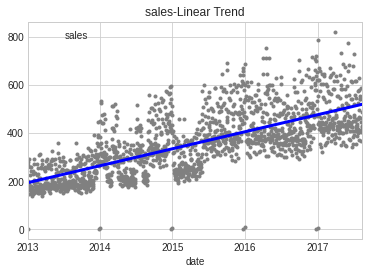

In [125]:
y_pred=pd.Series(model.predict(X),index=X.index)
ax=daily_sales.plot(style='.',color='0.5',title='sales-Linear Trend')
linear_=y_pred.plot(ax=ax,color='blue',linewidth=3,label='linear Trend')

In [126]:
X=dp.out_of_sample(steps=138)
y_forecast=pd.Series(model.predict(X),index=X.index)
y_forecast.tail()

2017-12-27    545.836983
2017-12-28    546.030240
2017-12-29    546.223498
2017-12-30    546.416755
2017-12-31    546.610012
Freq: D, dtype: float64

선형 회귀와 out_of sample를 통해 예측해보기

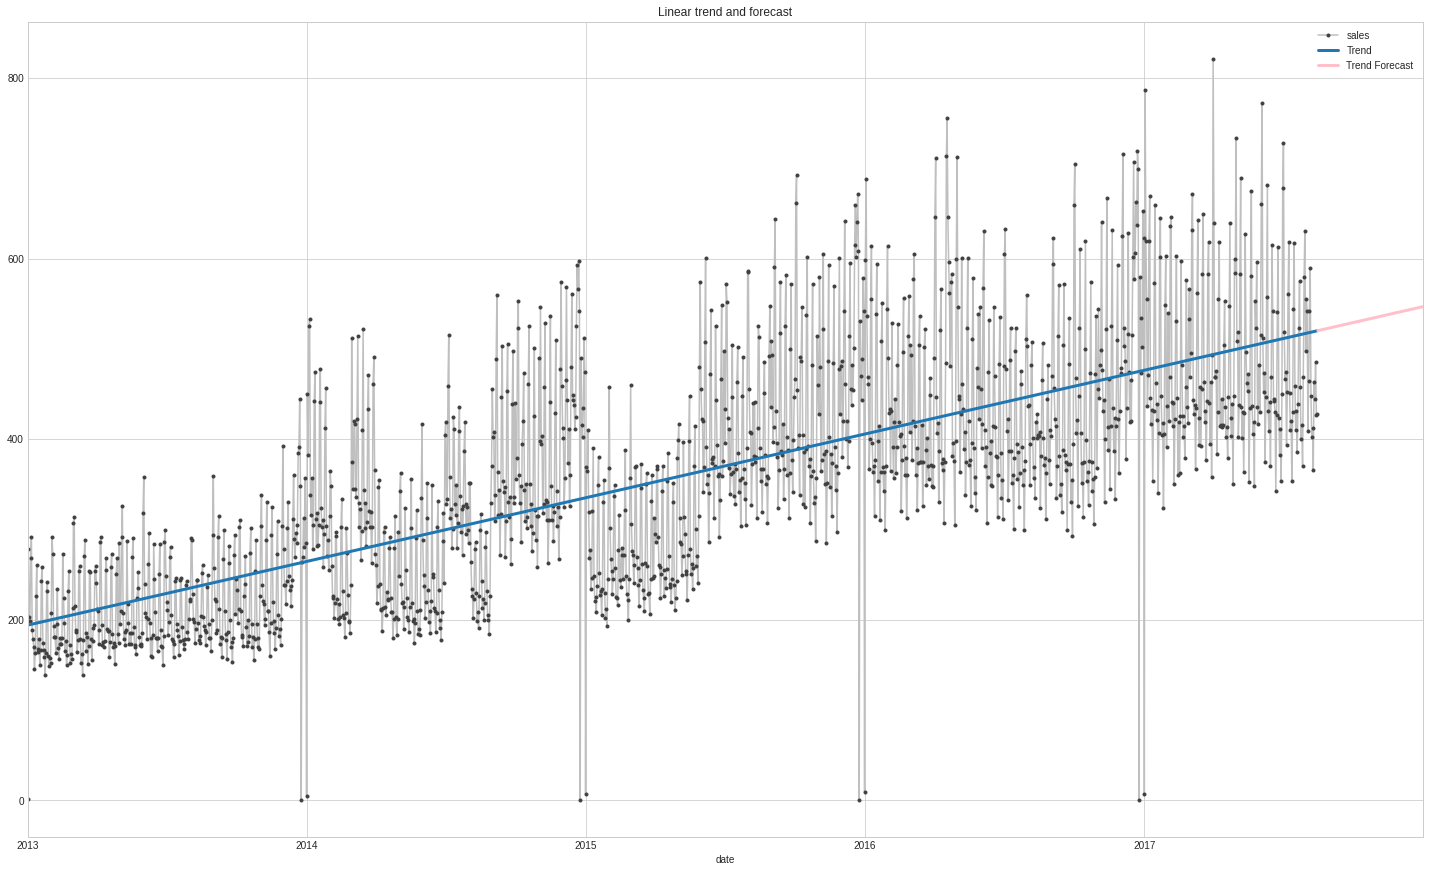

In [127]:
fig,axes=plt.subplots(1,1,figsize=(25,15))
ax2=daily_sales.plot(title='Linear trend and forecast',ax=axes,**plot_params)
ax3=y_pred.plot(ax=ax2,linewidth=3,label='Trend')
ax3=y_forecast.plot(ax=ax3,linewidth=3,label='Trend Forecast',color='pink')
_=ax3.legend()

### EDA


어떤 것들이 상점의 매출에 영향을 주는지 파악해보자

월 별로 분석해보자

[]

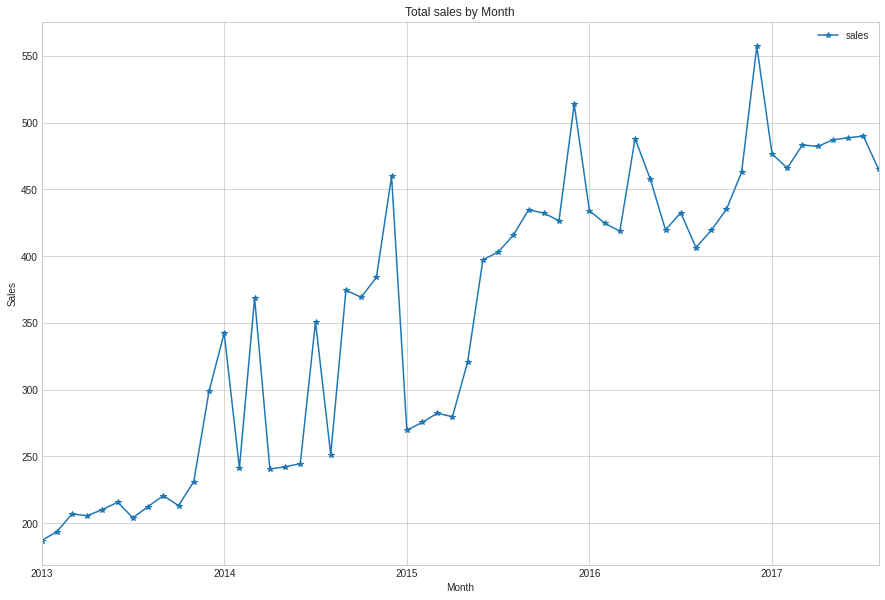

In [116]:
monthly_sales.plot(kind='line',figsize=(15,10),marker='*')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Total sales by Month')
plt.plot()

연말로 갈수록 우상향

연도가 늘어날수록 우상향

연초마다 떡락하는 건 쉬는 날이라서?

**그럼 혹시 promotion과 sales간의 관계?**

할인한 게 많을수록 판매금액 높더라?

Text(0.5, 1.0, 'Relationship between Promotion and Sales')

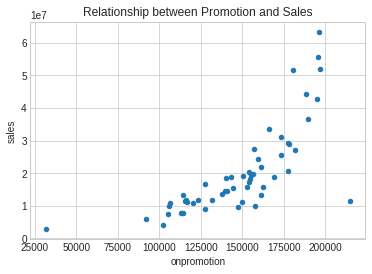

In [137]:
promotion_sales=train_.groupby('store_nbr')[['onpromotion','sales']].sum()
promotion_sales.plot.scatter('onpromotion','sales')
plt.title('Relationship between Promotion and Sales')

**store별 판매량 비교**

가게 번호별로 판매량을 확인할 수 있음

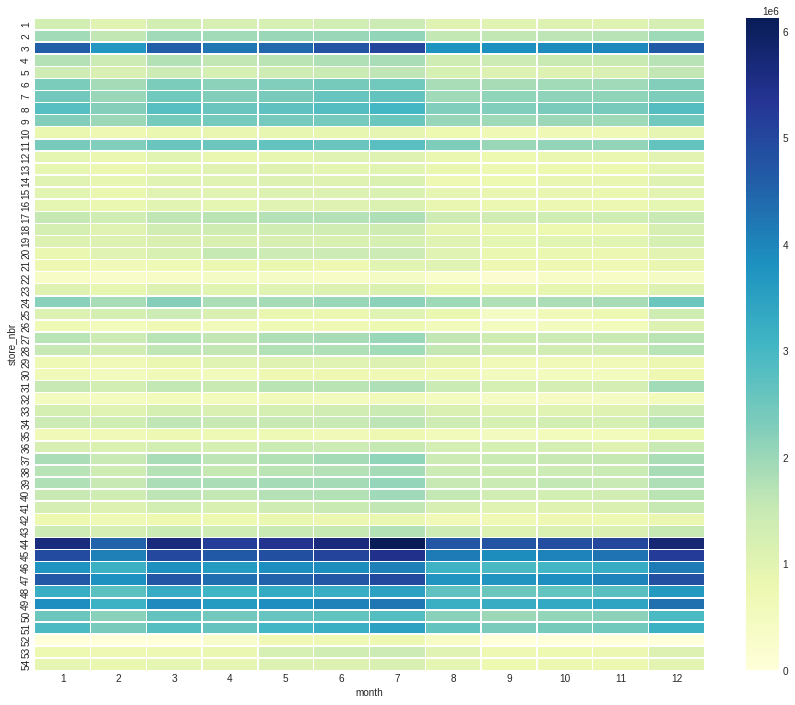

In [ ]:
table=pd.pivot_table(train_,values='sales',index=['store_nbr'],columns=['month'],aggfunc=np.sum)
fig,ax=plt.subplots(figsize=(15,12))
sns.heatmap(table,annot=False,linewidths=.5,ax=ax,cmap='YlGnBu')
plt.show()

**제품별 판매량 비교**

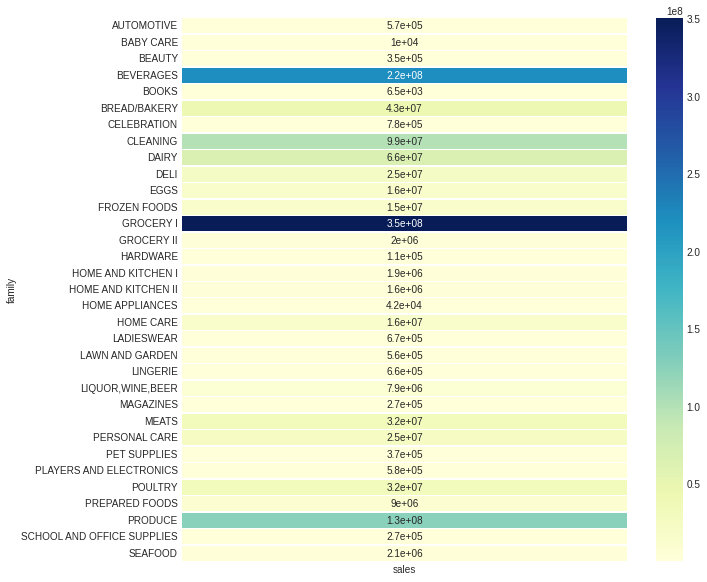

In [ ]:
sales_table=pd.pivot_table(train_,values='sales',index=['family'],aggfunc=np.sum)
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(sales_table,annot=True,linewidths=.5,ax=ax,cmap='YlGnBu')
plt.show()

**어느 요일**에 잘 팔리냐

주말에 확실히 장사가 잘되네

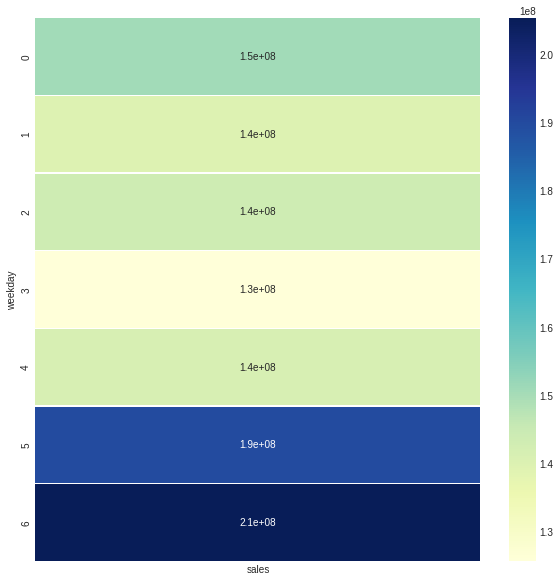

In [ ]:
day_table=pd.pivot_table(train_,values='sales',index=['weekday'],aggfunc=np.sum)
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(day_table,annot=True,linewidths=.5,ax=ax,cmap="YlGnBu")
plt.show()

**family : 판매 제품 타입**

어떤 게 제일 잘 팔릴까?

In [150]:
sales_family=train_cp.groupby('family')['sales'].mean().sort_values(ascending=False).to_frame()
sales_family

,sales
family,
GROCERY I,3790.432861
BEVERAGES,2394.912598
PRODUCE,1355.373657
CLEANING,1074.171509
DAIRY,711.175964
BREAD/BAKERY,464.150604
POULTRY,351.078827
MEATS,341.965912
PERSONAL CARE,271.192383


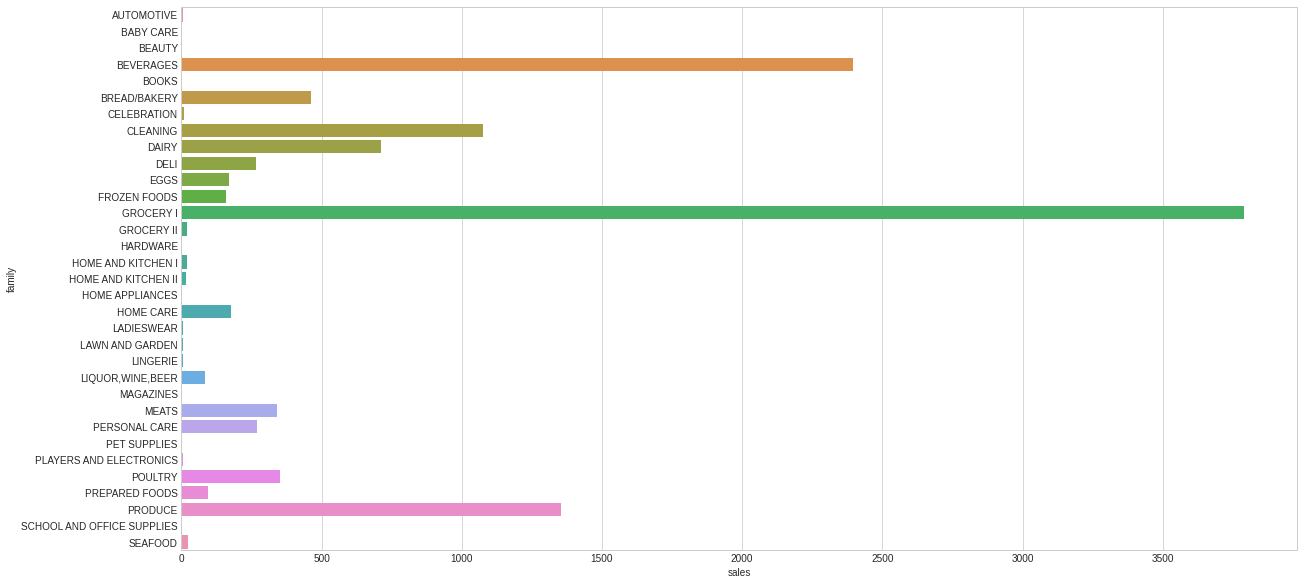

In [151]:
plt.figure(figsize=(20,10))
sns.barplot(data=sales_family,y=sales_family.index,x=sales_family.sales)
plt.show()

식료품이 제일 많이 팔리는 것을 볼 수 있음

하드웨어, 책 등은 덜 팔림

In [152]:
print('The best family products sell are: ',sales_family.index[:5])
print('\nThe worst family products sell are: ',sales_family.index[-5:])

The best family products sell are:  CategoricalIndex(['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING', 'DAIRY'], categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, dtype='category', name='family')

The worst family products sell are:  CategoricalIndex(['MAGAZINES', 'HARDWARE', 'HOME APPLIANCES', 'BABY CARE',
                  'BOOKS'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, dtype='category', name='family')


## Machine learning model

xgboost lightgbm 모델 사용할 것임

In [140]:
from sklearn.preprocessing import *
encoder=LabelEncoder()
encoder.fit(train_['family'])
train_['family']=encoder.transform(train_['family'])
test_['family']=encoder.transform(test_['family'])

In [148]:
train_.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 3054348 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 18 columns):
 #   Column         Dtype   
---  ------         -----   
 0   store_nbr      int64   
 1   family         int64   
 2   sales          float32 
 3   onpromotion    uint32  
 4   city           category
 5   state          category
 6   type           category
 7   cluster        category
 8   oilprice       float64 
 9   holidays_type  category
 10  locale         category
 11  locale_name    category
 12  description    category
 13  transferred    object  
 14  year           int64   
 15  weekday        int64   
 16  month          int64   
 17  day            int64   
dtypes: category(8), float32(1), float64(1), int64(6), object(1), uint32(1)
memory usage: 256.3+ MB


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset
from sklearn.compose import make_column_transformer
OHEC=OneHotEncoder(
    drop='if_binary',
    handle_unknown='ignore'
)


In [ ]:
## machine learning model